# Домашняя работа

In [1]:
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek, SMOTEENN

from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
ROOT_PATH = Path('..')
DATA_ROOT_PATH = ROOT_PATH / 'data'
RAW_DATA_PATH = DATA_ROOT_PATH / 'raw'
DATASET_FILENAME = 'healthcare-dataset-stroke-data.csv'

In [3]:
data_path = RAW_DATA_PATH / DATASET_FILENAME
if not data_path.exists():
    print(f'Dataset is not presented in {RAW_DATA_PATH}. Please put it there to proceed')

#### 1. Загрузите данные

In [4]:
df = pd.read_csv(data_path)
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


#### 2. Опишите задачу словами. В том числе напишите, что значит каждый признак  
Требуется сделать модель, прогнозирующую склонность к инсульту у пациента

In [5]:
feature_names = df.columns
summary = defaultdict(list)
for feature in feature_names:
    summary[feature].append(str(df[feature].dtype))
    if 'float' not in summary[feature][-1] and feature != 'id':
        summary[feature].append([_ for _ in df[feature].unique()])
for f, v in summary.items():
    print(f'{f}:\n\t{v}')

id:
	['int64']
gender:
	['object', ['Male', 'Female', 'Other']]
age:
	['float64']
hypertension:
	['int64', [0, 1]]
heart_disease:
	['int64', [1, 0]]
ever_married:
	['object', ['Yes', 'No']]
work_type:
	['object', ['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked']]
Residence_type:
	['object', ['Urban', 'Rural']]
avg_glucose_level:
	['float64']
bmi:
	['float64']
smoking_status:
	['object', ['formerly smoked', 'never smoked', 'smokes', 'Unknown']]
stroke:
	['int64', [1, 0]]


Признаки:
- gender - пол (почти бинарный: Male, Female, Other)
- age    - возраст (число с плавающей точкой)
- hypertension - наличие/отсутствие гипертонии (бинарный)
- heart_disease - наличие/отсутствие заболеваний сердца (бинарный)
- ever_married - был ли женат/замужем (бинарный)
- work_type - вид деятельности/работы (категориальный: children, Govt_job, Never_worked, Private, Self-employed)
- Residence_type - тип места жительства (категориальный: Rural - деревня, Urban - город)
- avg_glucose_level - средний уровень глюкозы в крови (число с плавающей точкой)
- bmi - индекс массы тела (число с плавающей точкой)
- smoking_status - отношение к курению (категориальный: formerly smoked - курил в прошлом, never smoked - никогда не курил, smokes - курит, Unknown - неизвестно)
- stroke - целевая переменная (есть ли инсульт)

Итого количественных: 3, бинарных: 4, категориальных 3

In [6]:
quant_features = ['age', 'avg_glucose_level', 'bmi']
binary_features = ['gender', 'hypertension', 'heart_disease', 'ever_married']
categorical_features = ['work_type', 'Residence_type', 'smoking_status']

Проверим Other из gender

In [7]:
df[df['gender'] == 'Other']

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


Всего один пример, удалим

In [8]:
df = df.drop(df[df['gender'] == 'Other'].index)
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


Преобразуем значения бинарных признаков в (1, 0)

In [9]:
df['gender'].replace(['Male', 'Female'], [1, 0], inplace=True)
df['ever_married'].replace(['Yes', 'No'], [1, 0], inplace=True)
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,0,61.0,0,0,1,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,1,80.0,0,1,1,Private,Rural,105.92,32.5,never smoked,1
3,60182,0,49.0,0,0,1,Private,Urban,171.23,34.4,smokes,1
4,1665,0,79.0,1,0,1,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,0,80.0,1,0,1,Private,Urban,83.75,NaN,never smoked,0
5106,44873,0,81.0,0,0,1,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,0,35.0,0,0,1,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,1,51.0,0,0,1,Private,Rural,166.29,25.6,formerly smoked,0


#### 3. Разбейте данные на обучающую и тестовую выборки  
Позже

#### 4. Визуализируйте данные из обучающей выборки. В частности, имеет смысл построить диаграммы рассеивания для количественных признаков. Построить гистограммы распределений и т.п. Вычислить основные характеристики (среднее, разброс, корреляционную матрицу и т.д.). Интерпретируйте результаты

Посмотрим числа случаев инсульта и случаев без инсульта

In [10]:
stroke_cases_df = df[df['stroke'] == 1]
no_stroke_cases_df = df[df['stroke'] == 0]
print(f"stroke cases:\t{len(stroke_cases_df)}\nno stroke:\t{len(no_stroke_cases_df)}")

stroke cases:	249
no stroke:	4860


Видим, что примеров без инсульта значительно больше чем примеров с инсультом. Считаем набор данных не сбалансированным. В дальнейшем будем считать, что примеры с инсультом имеют большую "ценность" чем примеры без инсульта

построим диаграммы  рассеяния для всего набора данных и отдельно данных с инсультом и данных без инсульта

In [11]:
# pd.plotting.scatter_matrix(df.drop(['id'], axis=1))

In [12]:
# pd.plotting.scatter_matrix(stroke_cases_df.drop(['id', 'stroke'], axis=1))

In [13]:
# pd.plotting.scatter_matrix(no_stroke_cases_df.drop(['id', 'stroke'], axis=1))

построим гистограммы для всего набора данных и отдельно данных с инсультом и данных без инсульта

In [14]:
def plot_histograms(df, feature_names):
    fig, axs = plt.subplots(4, 3)
    for i, f in enumerate(feature_names):
        ax = axs[i // 3, i % 3]
        ax.set_title(f)
        df[f].hist(ax=ax, figsize=(12, 14), bins=20)

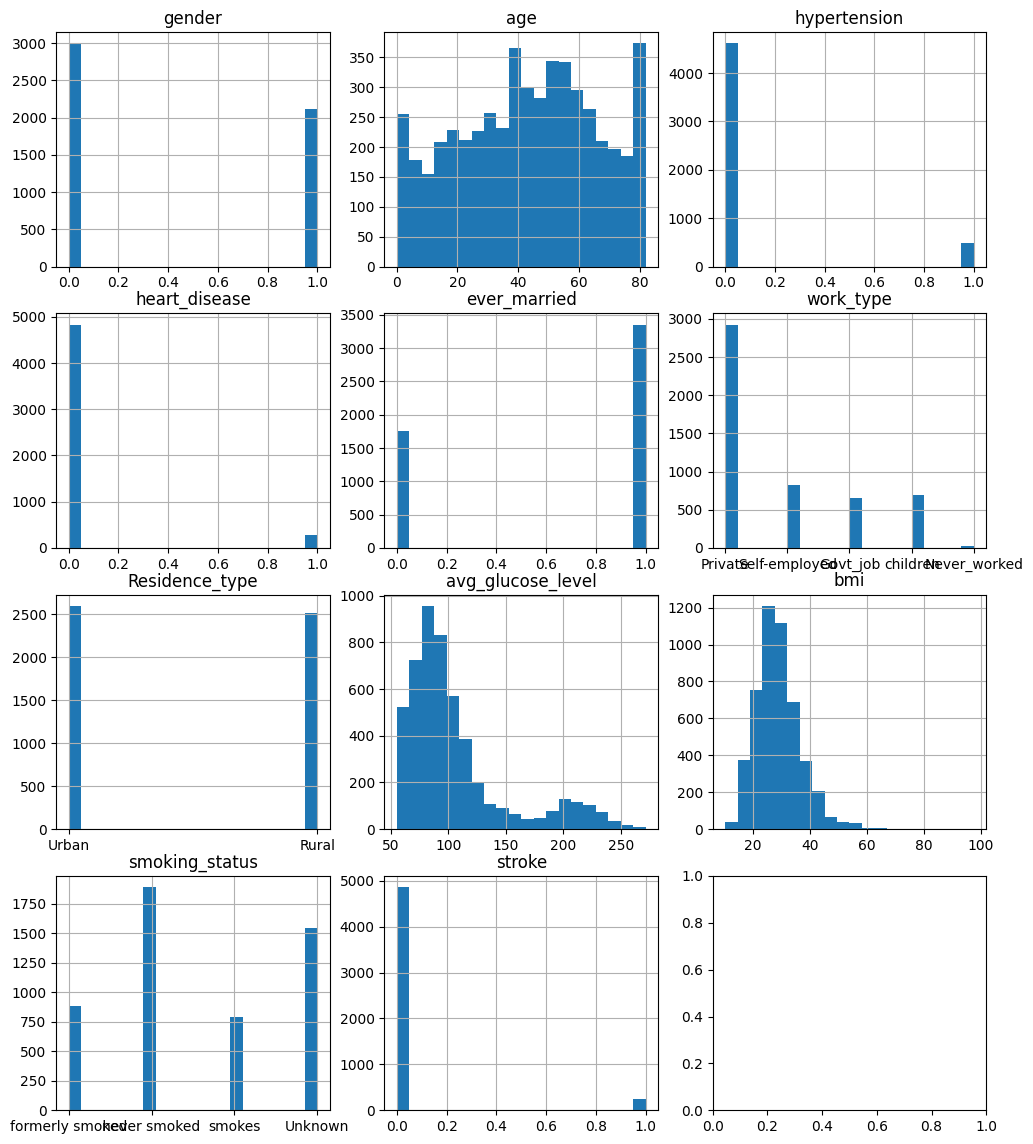

In [15]:
plot_histograms(df, feature_names[1:])

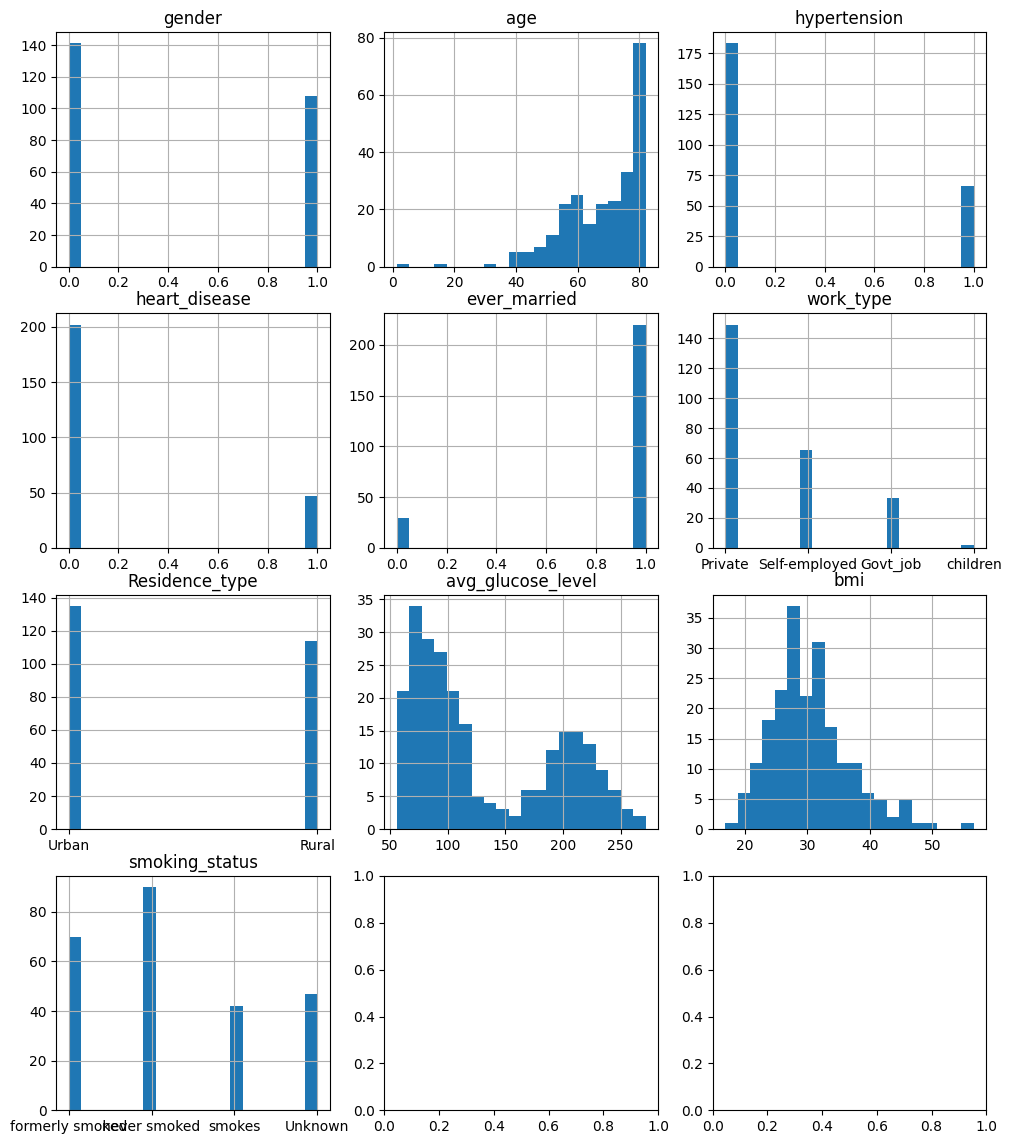

In [17]:
plot_histograms(stroke_cases_df, feature_names[1:-1])

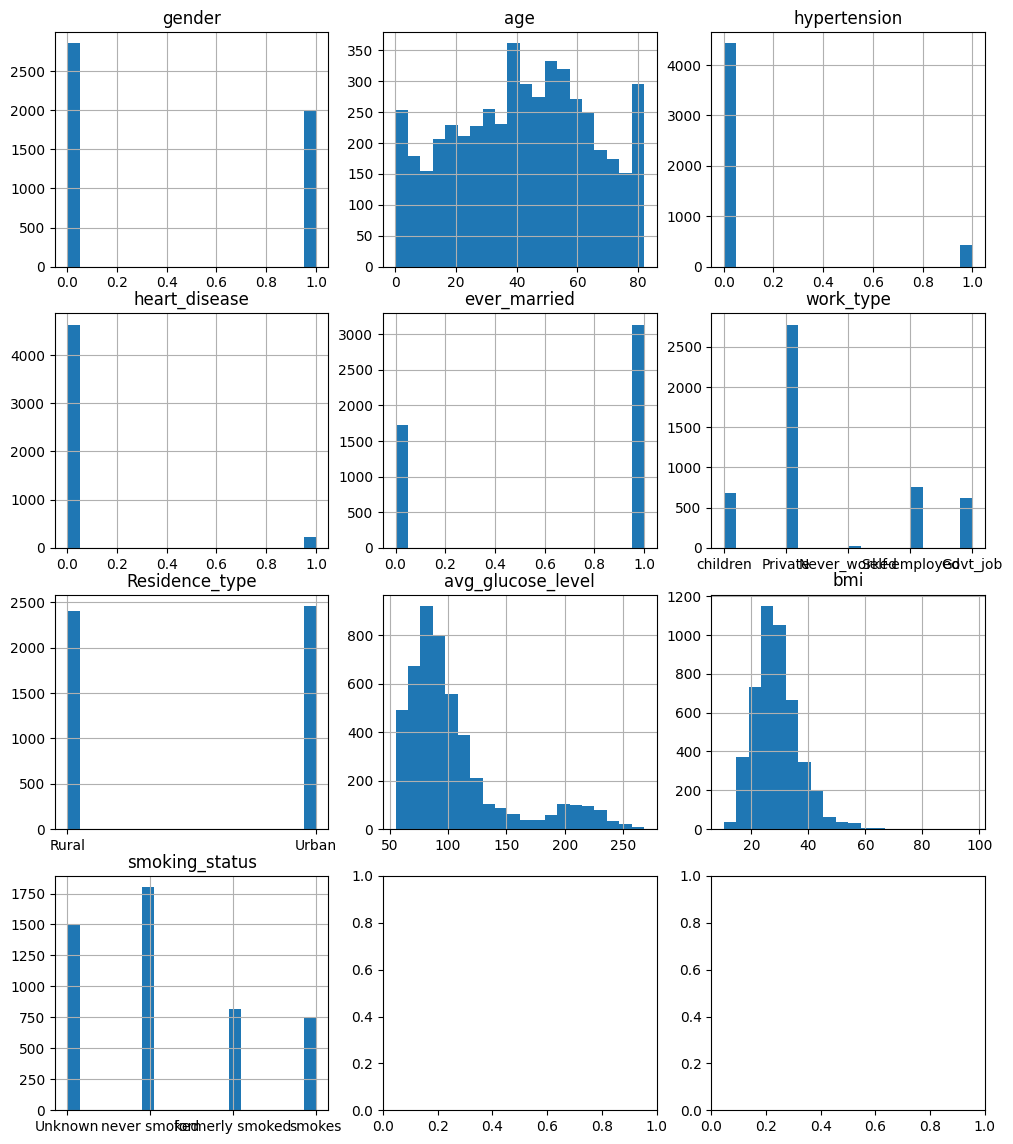

In [18]:
plot_histograms(no_stroke_cases_df, feature_names[1:-1])

Среднее, разброс, корреляционная матрица

In [19]:
print('без учёта категориальных и бинарных')
tdf = df.drop(['id'] + categorical_features + binary_features, axis=1)
print(f'\nсреднее:\n{tdf.drop(["stroke"], axis=1).mean()}')
print(f'\nразброс:\n{tdf.drop(["stroke"], axis=1).var()}')
print(f'\n корр.матрица:\n{tdf.corr()}')
print('\nс учётом категориальных и бинарных')
tdf = df.drop(['id'], axis=1)
print(f'\nсреднее:\n{tdf.mean()}')
print(f'\nразброс:\n{tdf.var()}')
print(f'\nкорр.матрица:\n{tdf.corr()}')

без учёта категориальных и бинарных

среднее:
age                   43.229986
avg_glucose_level    106.140399
bmi                   28.894560
dtype: float64

разброс:
age                   511.373788
avg_glucose_level    2050.731557
bmi                    61.690341
dtype: float64

 корр.матрица:
                        age  avg_glucose_level       bmi    stroke
age                1.000000           0.238323  0.333314  0.245239
avg_glucose_level  0.238323           1.000000  0.175672  0.131991
bmi                0.333314           0.175672  1.000000  0.042341
stroke             0.245239           0.131991  0.042341  1.000000

с учётом категориальных и бинарных

среднее:
gender                 0.413975
age                   43.229986
hypertension           0.097475
heart_disease          0.054022
ever_married           0.656293
avg_glucose_level    106.140399
bmi                   28.894560
stroke                 0.048738
dtype: float64

разброс:
gender                  0.242647
age     

/tmp/ipykernel_730279/2412240056.py:8: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(f'\nсреднее:\n{tdf.mean()}')
/tmp/ipykernel_730279/2412240056.py:9: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(f'\nразброс:\n{tdf.var()}')
/tmp/ipykernel_730279/2412240056.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(f'\nкорр.матрица:\n{tdf.corr()}')

/tmp/ipykernel_730279/3162962605.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(df.drop(['id'], axis=1).corr())
/tmp/ipykernel_730279/3162962605.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.drop(['id'], axis=1).corr()


,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke
gender,1.000000,-0.027752,0.021223,0.085685,-0.030171,0.054722,-0.026164,0.009081
age,-0.027752,1.000000,0.276367,0.263777,0.679084,0.238323,0.333314,0.245239
hypertension,0.021223,0.276367,1.000000,0.108292,0.164187,0.174540,0.167770,0.127891
heart_disease,0.085685,0.263777,0.108292,1.000000,0.114601,0.161907,0.041322,0.134905
ever_married,-0.030171,0.679084,0.164187,0.114601,1.000000,0.155329,0.341553,0.108299
avg_glucose_level,0.054722,0.238323,0.174540,0.161907,0.155329,1.000000,0.175672,0.131991
bmi,-0.026164,0.333314,0.167770,0.041322,0.341553,0.175672,1.000000,0.042341
stroke,0.009081,0.245239,0.127891,0.134905,0.108299,0.131991,0.042341,1.000000


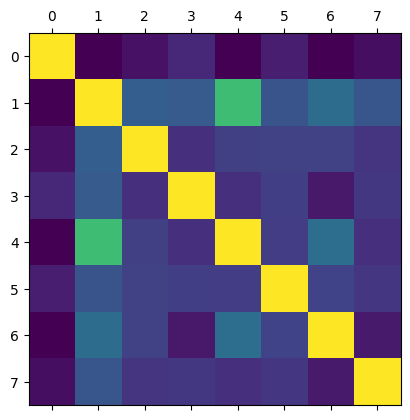

In [20]:
plt.matshow(df.drop(['id'], axis=1).corr())
df.drop(['id'], axis=1).corr()

#### 5. Обработать пропущенные значения (или убедиться, что их нет)

In [21]:
for f in feature_names[1:]:
    if len(df[df[f].isnull()]):
        print(f)
        print(f'{len(df[df[f].isnull()])} missing values')
    else:
        pass

bmi
201 missing values


In [22]:
len(df[df['bmi'].isnull()][df['stroke'] == 1])

/tmp/ipykernel_730279/2984968874.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(df[df['bmi'].isnull()][df['stroke'] == 1])


40

In [23]:
len(df[df['bmi'].isnull()][df['stroke'] == 0])

/tmp/ipykernel_730279/2179315829.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(df[df['bmi'].isnull()][df['stroke'] == 0])


161

Из 249 примеров без инсульта 40 пропущенных значений bmi (16%). Кажется много, попробуем их не отбрасывать  
Для этого оценим их значения по остальным признакам

In [24]:
predictions = df[df['bmi'].isnull()]
train = df[df['bmi'].notnull()]

Используем линейную регрессию для предсказания пропущенных значений bmi

In [25]:
from sklearn.linear_model import LinearRegression

In [26]:
model = LinearRegression()

In [27]:
model.fit(train.drop(['id', 'bmi'] + categorical_features, axis=1), train['bmi'])

LinearRegression()

In [28]:
predictions['bmi'] = model.predict(predictions.drop(['id', 'bmi'] + categorical_features, axis=1))
predictions

/tmp/ipykernel_730279/3418483109.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['bmi'] = model.predict(predictions.drop(['id', 'bmi'] + categorical_features, axis=1))


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,51676,0,61.0,0,0,1,Self-employed,Rural,202.21,31.488680,never smoked,1
8,27419,0,59.0,0,0,1,Private,Rural,76.15,29.068941,Unknown,1
13,8213,1,78.0,0,1,1,Private,Urban,219.84,30.957163,Unknown,1
19,25226,1,57.0,0,1,0,Govt_job,Urban,217.08,26.253551,Unknown,1
27,61843,1,58.0,0,0,1,Private,Rural,189.84,30.819652,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5039,42007,1,41.0,0,0,0,Private,Rural,70.15,25.661768,formerly smoked,0
5048,28788,1,40.0,0,0,1,Private,Urban,191.15,31.279537,smokes,0
5093,32235,0,45.0,1,0,1,Govt_job,Rural,95.02,32.277991,smokes,0
5099,7293,1,40.0,0,0,1,Private,Rural,83.94,29.318191,smokes,0


<AxesSubplot: >

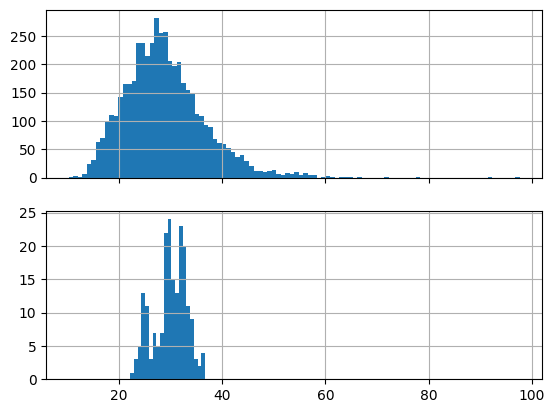

In [29]:
fig, axs = plt.subplots(2, 1, sharex=True)
train['bmi'].hist(ax=axs[0], bins=100)
predictions['bmi'].hist(ax=axs[1], bins=20)

Распределение предсказаний bmi отличается от распределения bmi в данных, но не выходит за область его значений и средние значения похожи. Предположим, что мы можем заменить NaN на предсказания

todo: попробовать улучшить предсказания

In [30]:
df.loc[df['bmi'].isnull(), 'bmi'] = predictions['bmi']
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,Private,Urban,228.69,36.600000,formerly smoked,1
1,51676,0,61.0,0,0,1,Self-employed,Rural,202.21,31.488680,never smoked,1
2,31112,1,80.0,0,1,1,Private,Rural,105.92,32.500000,never smoked,1
3,60182,0,49.0,0,0,1,Private,Urban,171.23,34.400000,smokes,1
4,1665,0,79.0,1,0,1,Self-employed,Rural,174.12,24.000000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,0,80.0,1,0,1,Private,Urban,83.75,34.058822,never smoked,0
5106,44873,0,81.0,0,0,1,Self-employed,Urban,125.20,40.000000,never smoked,0
5107,19723,0,35.0,0,0,1,Self-employed,Rural,82.99,30.600000,never smoked,0
5108,37544,1,51.0,0,0,1,Private,Rural,166.29,25.600000,formerly smoked,0


#### 6. Исключить нерелевантные признаки (об'яснить как вы их нашли)

Not implemented yet

#### 7. Если необходимо, то обработать коррелированные признаки

Коррелированных признаков не замечено

#### 8. Обработать категориальные признаки

In [31]:
for f in categorical_features:
    df[f].replace(df[f].unique(), [i for i in range(len(df[f].unique()))], inplace=True)
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,0,0,228.69,36.600000,0,1
1,51676,0,61.0,0,0,1,1,1,202.21,31.488680,1,1
2,31112,1,80.0,0,1,1,0,1,105.92,32.500000,1,1
3,60182,0,49.0,0,0,1,0,0,171.23,34.400000,2,1
4,1665,0,79.0,1,0,1,1,1,174.12,24.000000,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,0,80.0,1,0,1,0,0,83.75,34.058822,1,0
5106,44873,0,81.0,0,0,1,1,0,125.20,40.000000,1,0
5107,19723,0,35.0,0,0,1,1,1,82.99,30.600000,1,0
5108,37544,1,51.0,0,0,1,0,1,166.29,25.600000,0,0


#### 9. Провести масштабирование (или об'яснить, почему в вашем случае она не нужна)

Not implemented yet

#### 10. Вам может понадобиться другая предобработка. Например, если в вашем датасете есть текстовые признаки с уникальными значениями (например, аннотации товаров, отзывы пользователей, другие тексты), как в двух последних датасетах из перечисленных, то вам понадобится этап извлечения признаков, т.е.простые методы NLP, как, например, bag-of-words.  Воспользуйтесь библиотеками re, nltk

---

#### 11. После шагов 5-10 разумно вернуться к шагу 4 (а может возвращаться к нему после каждого из этапов 5-10)

---

#### 3. Разбейте данные на обучающую и тестовую выборки

Сделаем разбиение таким образом, чтобы в тестовом наборе было одинаковое количество примеров с инсультом и без

In [32]:
STROKE_TEST_SIZE = 50

In [33]:
s_df = df[df['stroke']==1]
sx_train, sx_test, sy_train, sy_test = \
train_test_split(s_df.drop(['id', 'stroke'], axis=1), s_df['stroke'], test_size=STROKE_TEST_SIZE, random_state=1)
n_df = df[df['stroke']==0]#.sample(250)
nx_train, nx_test, ny_train, ny_test = \
train_test_split(n_df.drop(['id', 'stroke'], axis=1), n_df['stroke'], test_size=STROKE_TEST_SIZE, random_state=1)

In [34]:
x_train = pd.concat([sx_train, nx_train], axis=0)
y_train = pd.concat([sy_train, ny_train], axis=0)
x_test = pd.concat([sx_test, nx_test], axis=0)
y_test = pd.concat([sy_test, ny_test], axis=0)

Попробуем несколько подходов к балансированию набора данных

In [35]:
def balance(balancer, x, y):
    return balancer.fit_resample(x, y)

In [36]:
def model_experiments(model):
    results = []
    for b in [RandomUnderSampler(), SMOTE(), SMOTEENN(), SMOTETomek()]:
        x, y = balance(b, x_train, y_train)
        model.fit(x, y)
        preds = model.predict(x_test)
        results.append(preds)
    for i, preds in enumerate(results):
        fpr, tpr, thr = roc_curve(y_true=y_test, y_score=preds)
        print(fpr, tpr)
        plt.plot(fpr, tpr)

#### 12. Попробуйте как минимум 3 метода классификации (регрессии). Объясните ваш выбор. Найдите значения метрик на обучающей и тестовой выборке. Сделайте вывод

Логистическая регрессия

[0.   0.32 1.  ] [0.   0.68 1.  ]
[0.   0.24 1.  ] [0.  0.5 1. ]
[0.   0.26 1.  ] [0.   0.58 1.  ]
[0.   0.24 1.  ] [0.   0.52 1.  ]


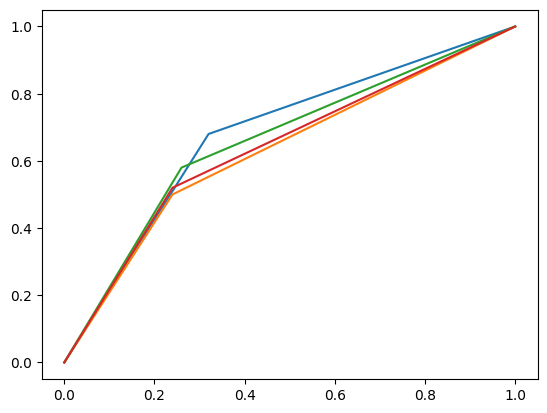

In [37]:
model_experiments(LogisticRegression(max_iter=1000))

[0.   0.34 1.  ] [0.   0.58 1.  ]
[0.   0.06 1.  ] [0.   0.22 1.  ]
[0.   0.18 1.  ] [0.   0.42 1.  ]
[0.   0.06 1.  ] [0.   0.22 1.  ]


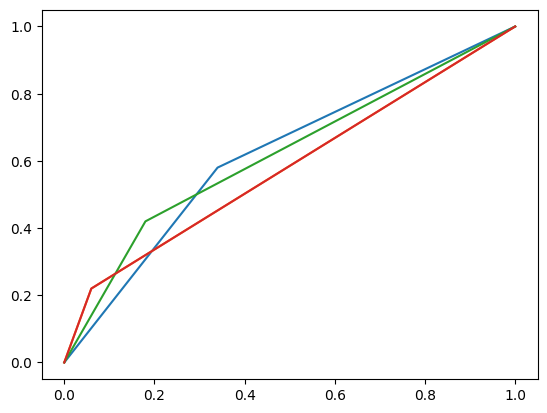

In [38]:
model_experiments(DecisionTreeClassifier())

/home/dmitry/learning/ml/НЕЙМАРК/repo/neymark_ml_course/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dmitry/learning/ml/НЕЙМАРК/repo/neymark_ml_course/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dmitry/learning/ml/НЕЙМАРК/repo/neymark_ml_course/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[0.   0.04 1.  ] [0.   0.14 1.  ]
[0.  0.3 1. ] [0.   0.56 1.  ]
[0.   0.24 1.  ] [0.   0.52 1.  ]
[0.  0.1 1. ] [0.   0.24 1.  ]


/home/dmitry/learning/ml/НЕЙМАРК/repo/neymark_ml_course/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


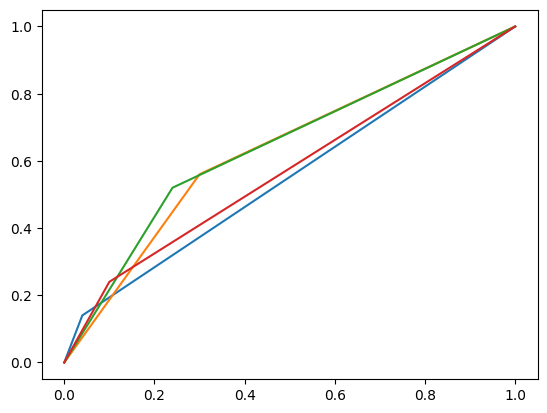

In [39]:
model_experiments(LinearSVC())